# Autoencoders on Fashionized MNIST

## Imports

In [24]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from neuralnetlib.models import Autoencoder
from scipy.stats import kurtosis, skew, pearsonr
from neuralnetlib.layers import Input, Conv2D, UpSampling2D, Flatten, Reshape, Dense
from neuralnetlib.preprocessing import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Fashion MNIST

In [9]:
print("Loading Fashion MNIST...")
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32') / 255.

X = X.reshape(-1, 28, 28, 1)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
print("Dataset shapes:")
print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Loading Fashion MNIST...


C:\Users\marcp\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset shapes:
Training data: (56000, 28, 28, 1)
Test data: (14000, 28, 28, 1)


## Create Autoencoder

In [10]:
autoencoder = Autoencoder(random_state=42, skip_connections=True)

### Encoder

In [11]:
autoencoder.add_encoder_layer(Input((28, 28, 1)))
autoencoder.add_encoder_layer(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
autoencoder.add_encoder_layer(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))

autoencoder.add_encoder_layer(Flatten())
autoencoder.add_encoder_layer(Dense(64, activation='relu'))  # Bottleneck

### Decoder

In [12]:
autoencoder.add_decoder_layer(Dense(7 * 7 * 32, activation='relu'))
autoencoder.add_decoder_layer(Reshape((7, 7, 32)))

autoencoder.add_decoder_layer(UpSampling2D(size=(2, 2)))  # Output: 14x14x32
autoencoder.add_decoder_layer(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))

autoencoder.add_decoder_layer(UpSampling2D(size=(2, 2)))  # Output: 28x28x16
autoencoder.add_decoder_layer(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))  # Output: 28x28x1

### Compile

In [13]:
autoencoder.compile(
    encoder_loss='mse',
    decoder_loss='mse',
    encoder_optimizer='adam',
    decoder_optimizer='adam',
    verbose=True
)

Autoencoder(temperature=1.0, gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=42, skip_connections=True, l1_reg=0.0, l2_reg=0.0)
-------------------------------------------------
Encoder:
Layer 1: Input(input_shape=(28, 28, 1))
Layer 2: Conv2D(num_filters=16, kernel_size=(3, 3), strides=(2, 2), padding=same)
Layer 3: Activation(ReLU)
Layer 4: Conv2D(num_filters=32, kernel_size=(3, 3), strides=(2, 2), padding=same)
Layer 5: Activation(ReLU)
Layer 6: Flatten
Layer 7: Dense(units=64)
Layer 8: Activation(ReLU)
-------------------------------------------------
Decoder:
Layer 1: Dense(units=1568)
Layer 2: Activation(ReLU)
Layer 3: Reshape(target_shape=(7, 7, 32))
Layer 4: UpSampling2D(size=(2, 2), interpolation=nearest)
Layer 5: Conv2D(num_filters=16, kernel_size=(3, 3), strides=(1, 1), padding=same)
Layer 6: Activation(ReLU)
Layer 7: UpSampling2D(size=(2, 2), interpolation=nearest)
Layer 8: Conv2D(num_filters=1, kernel_size=(3, 3), strides=(1, 1), padding=sam

## Train

In [14]:
history = autoencoder.fit(
    X_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_test,),
    verbose=True,
)

[==============================] 100% Epoch 1/5 - loss: 0.0650 -  - 176.39s
[==============================] 100% Epoch 2/5 - loss: 0.0225 -  - 168.33s
[==============================] 100% Epoch 3/5 - loss: 0.0193 -  - 171.68s
[==============================] 100% Epoch 4/5 - loss: 0.0177 -  - 174.72s
[==============================] 100% Epoch 5/5 - loss: 0.0166 -  - 183.86s


## Visualize Original vs Reconstructed Images

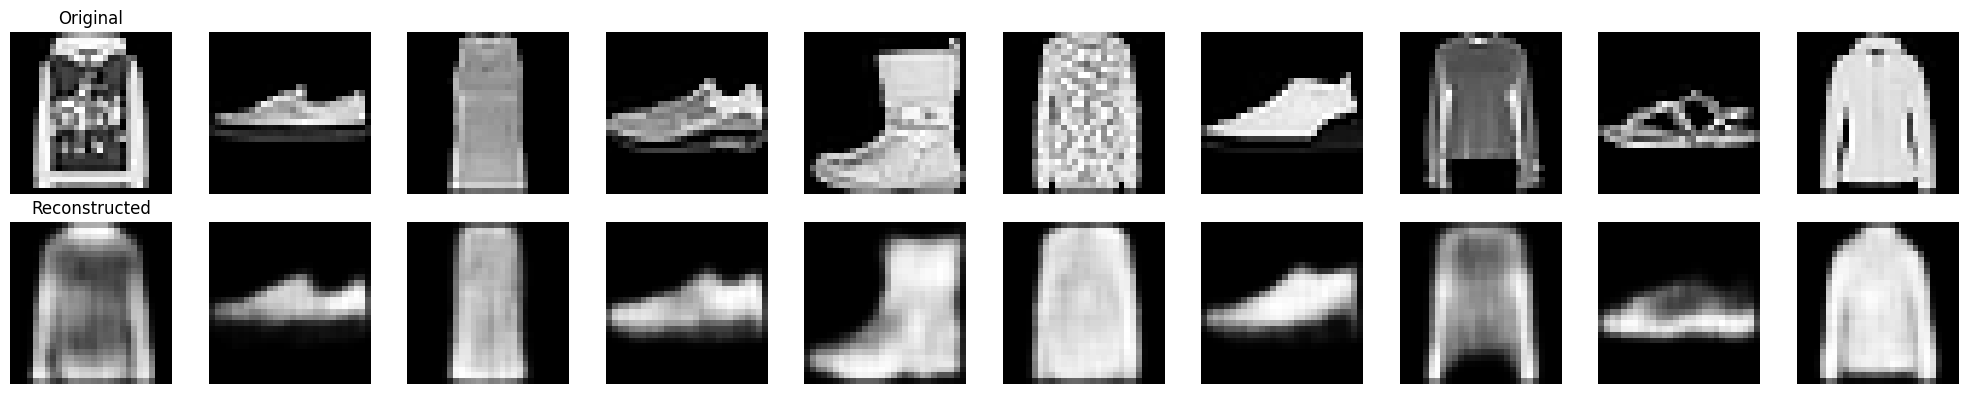

In [15]:
n = 10  # Number of images to display
decoded_imgs = autoencoder.predict(X_test[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

    # Reconstructed
    plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')

plt.tight_layout()
plt.show()

## Visualize Latent Space

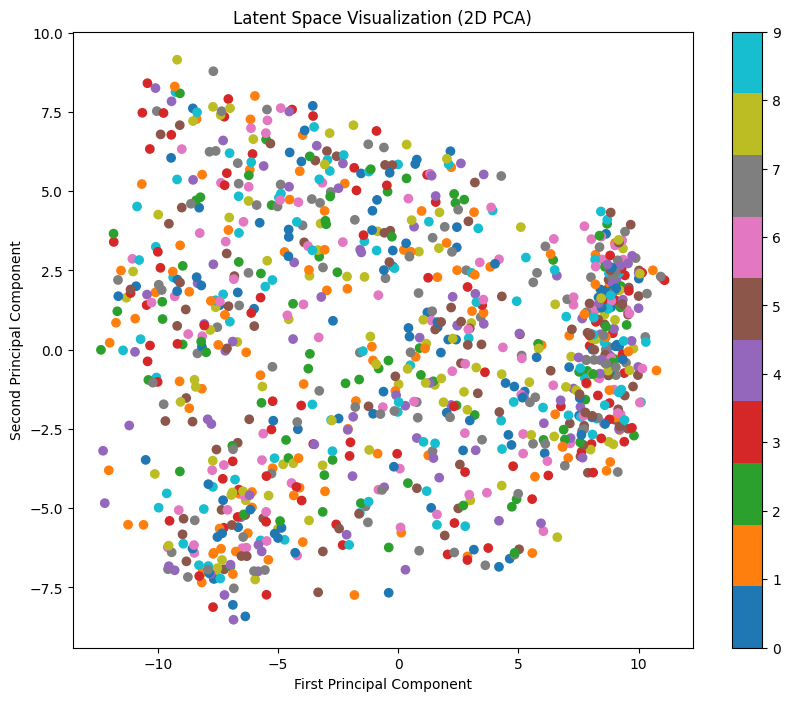

In [16]:
latent_vectors = autoencoder.predict(X_test[:1000], output_latent=True)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y[:1000].astype(int), cmap='tab10')
plt.colorbar()
plt.title('Latent Space Visualization (2D PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## Evaluate the model

Predicting on test set: 100%|██████████| 438/438 [00:51<00:00,  8.57it/s]


Computing MSE and MAE...


Calculating feature correlations: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


Text(0.5, 1.0, 'Latent Space Distribution')

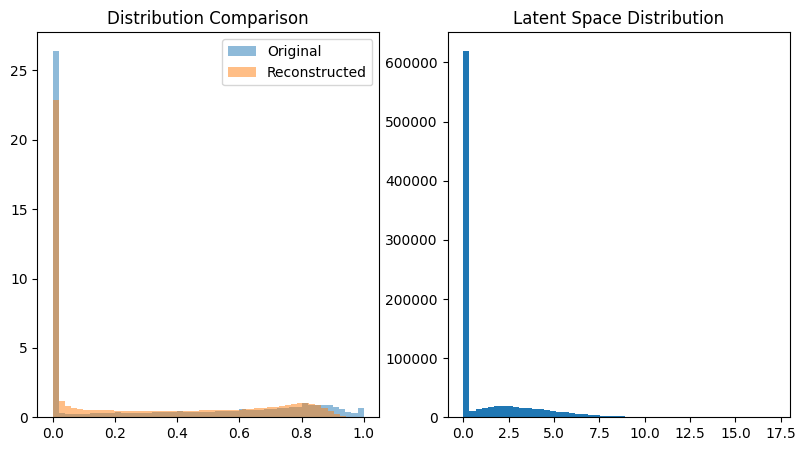

In [28]:
results = {}

# 1. Reconstruction Error Metrics
def batch_predict(model, data, batch_size=128):
    predictions = []
    for i in tqdm(range(0, data.shape[0], batch_size), desc='Predicting on test set'):
        batch = data[i:i+batch_size]
        predictions.append(model.predict(batch))
    return np.concatenate(predictions, axis=0)

X_test_reconstructed = batch_predict(autoencoder, X_test, batch_size=128)
X_train_reconstructed = batch_predict(autoencoder, X_train, batch_size=128)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_reconstructed_flat = X_test_reconstructed.reshape(X_test_reconstructed.shape[0], -1)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_train_reconstructed_flat = X_train_reconstructed.reshape(X_train_reconstructed.shape[0], -1)

print("Computing MSE and MAE...")
results['mse_test'] = mean_squared_error(X_test_flat, X_test_reconstructed_flat)
results['mae_test'] = mean_absolute_error(X_test_flat, X_test_reconstructed_flat)
results['mse_train'] = mean_squared_error(X_train_flat, X_train_reconstructed_flat)
results['mae_train'] = mean_absolute_error(X_train_flat, X_train_reconstructed_flat)

# 2. Feature Preservation
correlations = []
n_features_to_check = X_test.shape[-1]  # Number of channels
for i in tqdm(range(n_features_to_check), desc='Calculating feature correlations'):
    # Compute correlation for each channel
    corr, _ = pearsonr(X_test[..., i].ravel(), X_test_reconstructed[..., i].ravel())
    if not np.isnan(corr):
        correlations.append(corr)
results['avg_feature_correlation'] = np.mean(correlations)

# 3. Latent Space Analysis
latent_train = autoencoder.predict(X_train, output_latent=True)
latent_test = autoencoder.predict(X_test, output_latent=True)

latent_test_flat = latent_test.reshape(latent_test.shape[0], -1)

results['latent_skewness'] = np.mean([np.abs(skew(latent_test_flat[:, i]))
                                      for i in range(latent_test_flat.shape[1])])
results['latent_kurtosis'] = np.mean([kurtosis(latent_test_flat[:, i], fisher=True)
                                      for i in range(latent_test_flat.shape[1])])
# 4. Compression Efficiency
n_input_features = X_test.shape[1]
n_latent_features = latent_test.shape[1]
results['compression_ratio'] = n_input_features / n_latent_features

pca = PCA(n_components=n_latent_features)
pca.fit(latent_test)
results['explained_variance_ratio'] = pca.explained_variance_ratio.sum()

# 5. Distribution Matching
def approximate_kl_divergence(p, q):
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    p = p / p.sum()
    q = q / q.sum()
    return np.sum(p * np.log(p / q))

kl_divs = []
n_features_to_check = min(10, X_test.shape[1])
for i in range(n_features_to_check):
    hist_orig, _ = np.histogram(X_test[:, i], bins=50, density=True)
    hist_recon, _ = np.histogram(X_test_reconstructed[:, i], bins=50, density=True)
    kl_divs.append(approximate_kl_divergence(hist_orig, hist_recon))
results['avg_kl_divergence'] = np.mean(kl_divs)

# 6. Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(X_test.ravel(), bins=50, alpha=0.5, label='Original', density=True)
plt.hist(X_test_reconstructed.ravel(), bins=50, alpha=0.5, label='Reconstructed', density=True)
plt.title('Distribution Comparison')
plt.legend()

plt.subplot(132)
plt.hist(latent_test.ravel(), bins=50)
plt.title('Latent Space Distribution')

In [30]:
print("Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v}")

Evaluation Results:
mse_test: 0.016185486406242986
mae_test: 0.06812355394634412
mse_train: 0.016325908052845575
mae_train: 0.06847735954559486
avg_feature_correlation: 0.9334203364693552
latent_skewness: nan
latent_kurtosis: nan
compression_ratio: 0.4375
explained_variance_ratio: 1.0000000000000093
avg_kl_divergence: 0.16701555928701514
